### Zonal means of differences in Alk and Alk_alt

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import pop_tools 
from pint import UnitRegistry
import utils
import ncar_jobqueue
from dask.distributed import Client

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### PREP

In [2]:
variables = ['ALK','ALK_noGCB','ALK_2xGCB','PD']

### Get 5th IAF cycle

In [3]:
years='0249-0310'

In [4]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [5]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [6]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.PD.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['PD']=ds_tmp['PD']

In [7]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [8]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

#### GET WOA for coords

In [9]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [10]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

### Use Mike's method of computing zonal means

from importlib import reload
reload(utils)

In [12]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(cesm_ann_ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/work/kristenk/ebdg2r4c.nc
za ran successfully, writing netcdf output
doing variable: ALK_noGCB
Wrote dataset to /glade/work/kristenk/0g658omr.nc
za ran successfully, writing netcdf output
doing variable: ALK_2xGCB
Wrote dataset to /glade/work/kristenk/69mmcjmd.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/work/kristenk/zun14qwx.nc
za ran successfully, writing netcdf output


In [26]:
lats = da_zonal_mean['ALK'].lat_t.values
lats.shape

(394,)

In [27]:
depths = da_zonal_mean['ALK'].z_t.values * 0.01
depths.shape

(60,)

In [28]:
alk_noGCBdiff_zonal_iaf5 = da_zonal_mean['ALK_noGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
alk_2xGCBdiff_zonal_iaf5 = da_zonal_mean['ALK_2xGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)

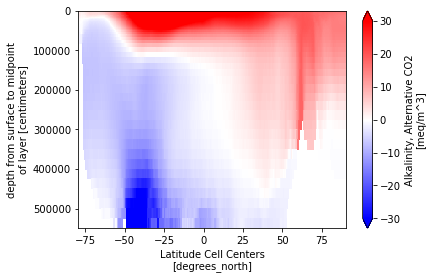

In [29]:
alk_noGCBdiff_global_zonal.plot(yincrease=False, vmin=-30, vmax=30, cmap='bwr')

In [24]:
global_zonal_pdens_iaf5 = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [25]:
alk_noGCBdiff_zonal_iaf5_top = alk_noGCBdiff_zonal_iaf5.isel(z_t=slice(0,40))
alk_noGCBdiff_zonal_iaf5_bottom = alk_noGCBdiff_zonal_iaf5.isel(z_t=slice(40,60))

alk_2xGCBdiff_zonal_iaf5_top = alk_2xGCBdiff_zonal_iaf5.isel(z_t=slice(0,40))
alk_2xGCBdiff_zonal_iaf5_bottom = alk_2xGCBdiff_zonal_iaf5.isel(z_t=slice(40,60))

pdens_glb_iaf5_top = global_zonal_pdens_iaf5.isel(z_t=slice(0,40))
pdens_glb_iaf5_bottom = global_zonal_pdens_iaf5.isel(z_t=slice(40,60))

z_top=depths[0:40]
z_bottom=depths[40:60]

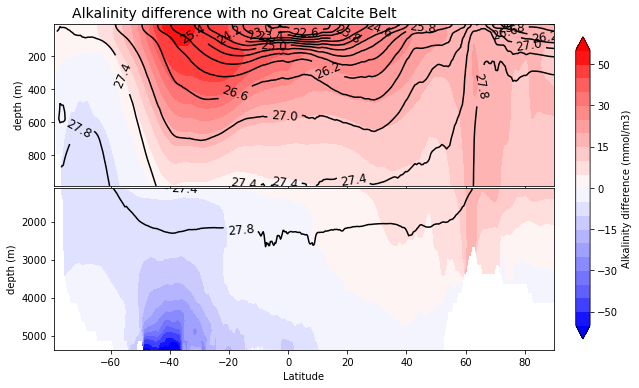

In [32]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,6))

plt.suptitle('Alkalinity difference with no Great Calcite Belt',x=0.15, y=0.92,fontsize=14,ha='left')

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf5_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf5_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf5_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf5_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.82,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)')
#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/global_zonal2.png', bbox_inches='tight', dpi=600);

### 4th IAF

In [33]:
years='0187-0248'

In [34]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [35]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [36]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.PD.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['PD']=ds_tmp['PD']

In [37]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [38]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [39]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(cesm_ann_ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/work/kristenk/aud8hgci.nc
za ran successfully, writing netcdf output
doing variable: ALK_noGCB
Wrote dataset to /glade/work/kristenk/bf2iz2_d.nc
za ran successfully, writing netcdf output
doing variable: ALK_2xGCB
Wrote dataset to /glade/work/kristenk/cc3ax49u.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/work/kristenk/xos6isbu.nc
za ran successfully, writing netcdf output


In [40]:
alk_noGCBdiff_zonal_iaf4 = da_zonal_mean['ALK_noGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
alk_2xGCBdiff_zonal_iaf4 = da_zonal_mean['ALK_2xGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
global_zonal_pdens_iaf4 = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [41]:
alk_noGCBdiff_zonal_iaf4_top = alk_noGCBdiff_zonal_iaf4.isel(z_t=slice(0,40))
alk_noGCBdiff_zonal_iaf4_bottom = alk_noGCBdiff_zonal_iaf4.isel(z_t=slice(40,60))

alk_2xGCBdiff_zonal_iaf4_top = alk_2xGCBdiff_zonal_iaf4.isel(z_t=slice(0,40))
alk_2xGCBdiff_zonal_iaf4_bottom = alk_2xGCBdiff_zonal_iaf4.isel(z_t=slice(40,60))

pdens_glb_iaf4_top = global_zonal_pdens_iaf4.isel(z_t=slice(0,40))
pdens_glb_iaf4_bottom = global_zonal_pdens_iaf4.isel(z_t=slice(40,60))

### and the 3rd IAF

In [42]:
years='0125-0186'

In [43]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [44]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [45]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.PD.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['PD']=ds_tmp['PD']

In [46]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [47]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [48]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(cesm_ann_ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/work/kristenk/nql7_4ud.nc
za ran successfully, writing netcdf output
doing variable: ALK_noGCB
Wrote dataset to /glade/work/kristenk/m9b5voif.nc
za ran successfully, writing netcdf output
doing variable: ALK_2xGCB
Wrote dataset to /glade/work/kristenk/k28_w58_.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/work/kristenk/s_2vs2qo.nc
za ran successfully, writing netcdf output


In [49]:
alk_noGCBdiff_zonal_iaf3 = da_zonal_mean['ALK_noGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
alk_2xGCBdiff_zonal_iaf3 = da_zonal_mean['ALK_2xGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
global_zonal_pdens_iaf3 = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [50]:
alk_noGCBdiff_zonal_iaf3_top = alk_noGCBdiff_zonal_iaf3.isel(z_t=slice(0,40))
alk_noGCBdiff_zonal_iaf3_bottom = alk_noGCBdiff_zonal_iaf3.isel(z_t=slice(40,60))

alk_2xGCBdiff_zonal_iaf3_top = alk_2xGCBdiff_zonal_iaf3.isel(z_t=slice(0,40))
alk_2xGCBdiff_zonal_iaf3_bottom = alk_2xGCBdiff_zonal_iaf3.isel(z_t=slice(40,60))

pdens_glb_iaf3_top = global_zonal_pdens_iaf3.isel(z_t=slice(0,40))
pdens_glb_iaf3_bottom = global_zonal_pdens_iaf3.isel(z_t=slice(40,60))

### 2ND IAF

In [51]:
years='0063-0124'

In [52]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [53]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [54]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.PD.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['PD']=ds_tmp['PD']

In [55]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [56]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [57]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(cesm_ann_ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/work/kristenk/t0a9mzvt.nc
za ran successfully, writing netcdf output
doing variable: ALK_noGCB
Wrote dataset to /glade/work/kristenk/htznt2rt.nc
za ran successfully, writing netcdf output
doing variable: ALK_2xGCB
Wrote dataset to /glade/work/kristenk/99_cj8la.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/work/kristenk/22u1mz3g.nc
za ran successfully, writing netcdf output


In [58]:
alk_noGCBdiff_zonal_iaf2 = da_zonal_mean['ALK_noGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
alk_2xGCBdiff_zonal_iaf2 = da_zonal_mean['ALK_2xGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
global_zonal_pdens_iaf2 = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [59]:
alk_noGCBdiff_zonal_iaf2_top = alk_noGCBdiff_zonal_iaf2.isel(z_t=slice(0,40))
alk_noGCBdiff_zonal_iaf2_bottom = alk_noGCBdiff_zonal_iaf2.isel(z_t=slice(40,60))

alk_2xGCBdiff_zonal_iaf2_top = alk_2xGCBdiff_zonal_iaf2.isel(z_t=slice(0,40))
alk_2xGCBdiff_zonal_iaf2_bottom = alk_2xGCBdiff_zonal_iaf2.isel(z_t=slice(40,60))

pdens_glb_iaf2_top = global_zonal_pdens_iaf2.isel(z_t=slice(0,40))
pdens_glb_iaf2_bottom = global_zonal_pdens_iaf2.isel(z_t=slice(40,60))

### 1ST IAF

In [60]:
years='0001-0062'

In [61]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [62]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [63]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.PD.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['PD']=ds_tmp['PD']

In [64]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [65]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [66]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(cesm_ann_ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/work/kristenk/t155btxw.nc
za ran successfully, writing netcdf output
doing variable: ALK_noGCB
Wrote dataset to /glade/work/kristenk/opk9zv8u.nc
za ran successfully, writing netcdf output
doing variable: ALK_2xGCB
Wrote dataset to /glade/work/kristenk/2_h4kyav.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/work/kristenk/01tjtu7z.nc
za ran successfully, writing netcdf output


In [68]:
alk_noGCBdiff_zonal_iaf1 = da_zonal_mean['ALK_noGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
alk_2xGCBdiff_zonal_iaf1 = da_zonal_mean['ALK_2xGCB'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)
global_zonal_pdens_iaf1 = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [69]:
alk_noGCBdiff_zonal_iaf1_top = alk_noGCBdiff_zonal_iaf1.isel(z_t=slice(0,40))
alk_noGCBdiff_zonal_iaf1_bottom = alk_noGCBdiff_zonal_iaf1.isel(z_t=slice(40,60))

alk_2xGCBdiff_zonal_iaf1_top = alk_2xGCBdiff_zonal_iaf1.isel(z_t=slice(0,40))
alk_2xGCBdiff_zonal_iaf1_bottom = alk_2xGCBdiff_zonal_iaf1.isel(z_t=slice(40,60))

pdens_glb_iaf1_top = global_zonal_pdens_iaf1.isel(z_t=slice(0,40))
pdens_glb_iaf1_bottom = global_zonal_pdens_iaf1.isel(z_t=slice(40,60))

## Make figure

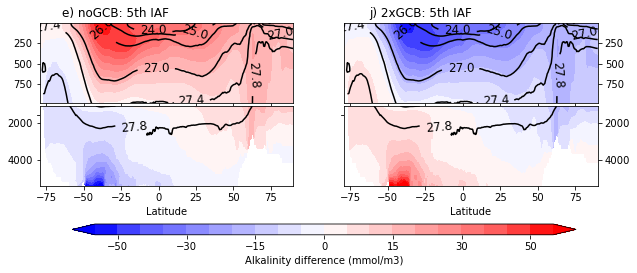

In [115]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [24., 25., 26., 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(2,2,1)
ax.set_title('e) noGCB: 5th IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf5_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf5_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,2,3)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf5_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf5_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('j) 2xGCB: 5th IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_2xGCBdiff_zonal_iaf5_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf5_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,4)
pc=ax.contourf(lats, z_bottom, alk_2xGCBdiff_zonal_iaf5_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf5_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_yaxis()

fig.subplots_adjust(hspace=0.03)
cbar_ax = fig.add_axes([0.17, -0.1, 0.7, 0.05])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)', orientation='horizontal')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonals5.pdf', bbox_inches='tight');

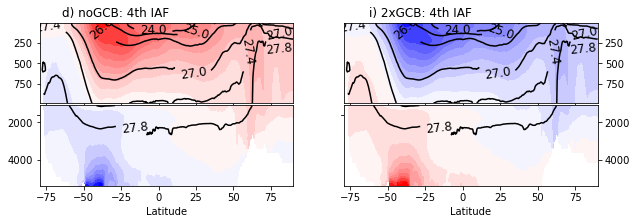

In [116]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [24., 25., 26., 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(2,2,1)
ax.set_title('d) noGCB: 4th IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf4_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf4_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,2,3)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf4_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf4_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('i) 2xGCB: 4th IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_2xGCBdiff_zonal_iaf4_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf4_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,4)
pc=ax.contourf(lats, z_bottom, alk_2xGCBdiff_zonal_iaf4_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf4_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_yaxis()

fig.subplots_adjust(hspace=0.03)
# cbar_ax = fig.add_axes([0.17, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)', orientation='horizontal')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonals4.pdf', bbox_inches='tight');

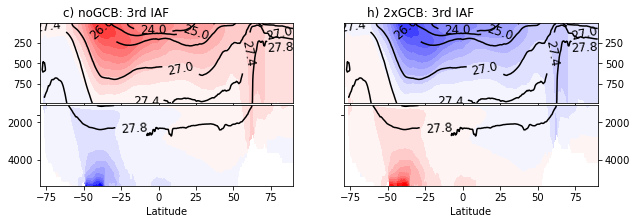

In [117]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [24., 25., 26., 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(2,2,1)
ax.set_title('c) noGCB: 3rd IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf3_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf3_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,2,3)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf3_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf3_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('h) 2xGCB: 3rd IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_2xGCBdiff_zonal_iaf3_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf3_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,4)
pc=ax.contourf(lats, z_bottom, alk_2xGCBdiff_zonal_iaf3_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf3_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_yaxis()

fig.subplots_adjust(hspace=0.03)
# cbar_ax = fig.add_axes([0.17, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)', orientation='horizontal')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonals3.pdf', bbox_inches='tight');

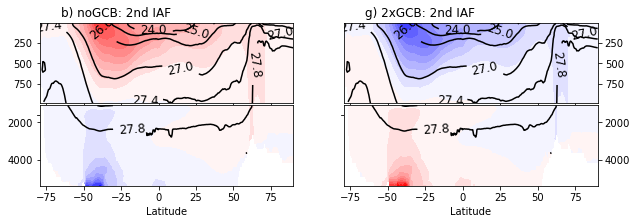

In [119]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [24., 25., 26., 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(2,2,1)
ax.set_title('b) noGCB: 2nd IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf2_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf2_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,2,3)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf2_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf2_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('g) 2xGCB: 2nd IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_2xGCBdiff_zonal_iaf2_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf2_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,4)
pc=ax.contourf(lats, z_bottom, alk_2xGCBdiff_zonal_iaf2_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf2_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_yaxis()

fig.subplots_adjust(hspace=0.03)
# cbar_ax = fig.add_axes([0.17, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)', orientation='horizontal')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonals2.pdf', bbox_inches='tight');

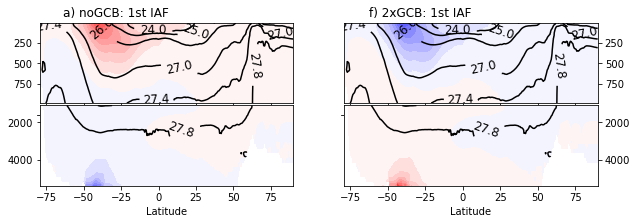

In [120]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [24., 25., 26., 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(2,2,1)
ax.set_title('a) noGCB: 1st IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_noGCBdiff_zonal_iaf1_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf1_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,2,3)
pc=ax.contourf(lats, z_bottom, alk_noGCBdiff_zonal_iaf1_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf1_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('f) 2xGCB: 1st IAF', fontsize=12, x=0.3)
pc=ax.contourf(lats, z_top, alk_2xGCBdiff_zonal_iaf1_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_iaf1_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.invert_yaxis()

ax = fig.add_subplot(2,2,4)
pc=ax.contourf(lats, z_bottom, alk_2xGCBdiff_zonal_iaf1_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_iaf1_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_yaxis()

fig.subplots_adjust(hspace=0.03)
# cbar_ax = fig.add_axes([0.17, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol/m3)', orientation='horizontal')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonals1.pdf', bbox_inches='tight');